In [1]:
# imports
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotting as myP
import numpy as np
import csv 
import match

In [2]:
# path variables 
path_cat = 'D:\IfA REU\Catalogs'
path_fig = 'D:\IfA REU\IfA-REU-Project\Figures'
path_csv = 'D:\IfA REU\IfA-REU-Project\Lists'

# Read CSV

In [3]:
# read from a given csv file and return a list of its contents 
def ReadFile(filename) : 
    # initialize list
    file = []
    # open csv file
    with open(filename, newline='') as csv_file : 
        reader = csv.reader(csv_file, delimiter=',', quotechar='"')
        # output file into list for easy access
        for row in reader :
            file.append(row)
    # print column names 
    print(filename, '\tcolumns: ', file[0])
    # return an array of type int with column names clipped off
    return(file[1:])

In [4]:
# read AGN ID and index from csv files
agn_irSel20 = np.array(ReadFile(path_csv+'\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv'), dtype=int)
zMatch      = np.array(ReadFile(path_cat+'\COSMOS_z_matches.csv'))

D:\IfA REU\IfA-REU-Project\Lists\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv 	columns:  ['ID', 'i']
D:\IfA REU\Catalogs\COSMOS_z_matches.csv 	columns:  ['ID', 'z']


In [5]:
# transpose arrays to get columns
agn_irSel20_id, agn_irSel20_i = agn_irSel20.T
zMatch_id, zMatch_z = zMatch.T

# get correct data type
zMatch_id = np.array(zMatch_id, dtype=int)
zMatch_z  = np.array(zMatch_z,  dtype=float)

# Read Catalog

In [6]:
# open COSMOS 2020 catalog file and get data 
inf20 = fits.open(path_cat+'\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
cols20 = inf20[1].columns
head20 = inf20[0].header
inf20.close()

In [7]:
# print(cols20)

# Get Data From Catalog 

In [8]:
# get photometry table values
flux_nu_uJy = np.array([   
        # The Galaxy Evolution Explorer (GALEX)
        np.array(data20['GALEX_FUV_FLUX']), 
        np.array(data20['GALEX_NUV_FLUX']),
        # Subaru / Hyper Suprime-Cam
        np.array(data20['HSC_g_FLUX_APER2']),
        np.array(data20['HSC_r_FLUX_APER2']),
        np.array(data20['HSC_i_FLUX_APER2']),
        np.array(data20['HSC_z_FLUX_APER2']),
        np.array(data20['HSC_y_FLUX_APER2']),
        # Paranal VISTA / VIRCAM
        np.array(data20['UVISTA_J_FLUX_APER2']),
        np.array(data20['UVISTA_H_FLUX_APER2']),
        np.array(data20['UVISTA_Ks_FLUX_APER2']),
        # Spitzer Large Area Survey with Hyper-Suprime-Cam (SPLASH) 
        np.array(data20['SPLASH_CH1_FLUX']),
        np.array(data20['SPLASH_CH2_FLUX']),
        np.array(data20['SPLASH_CH3_FLUX']),
        np.array(data20['SPLASH_CH4_FLUX']),
        # FIR
        np.array(data20['FIR_24_FLUX']),    # Spitzer/MIPS.24mu
        np.array(data20['FIR_100_FLUX']),   # Herschel/Pacs.green
        np.array(data20['FIR_160_FLUX']),   # Herschel/Pacs.red
        np.array(data20['FIR_250_FLUX']),   # Herschel/SPIRE.PSW
        np.array(data20['FIR_350_FLUX']),   # Herschel/SPIRE.PMW
        np.array(data20['FIR_500_FLUX'])    # Herschel/SPIRE.PLW
    ])  

# transpose so [i] is a source, not a column
flux_nu_uJy = flux_nu_uJy.T

# change -99 to NaN
flux_nu_uJy = np.where(flux_nu_uJy == float(-99), float('nan'), flux_nu_uJy)

# print info
print('Table shape:', np.shape(flux_nu_uJy))

Table shape: (1720700, 20)


In [9]:
# list wavelengths of the photometry filters (in Angstroms)
# -- Used lambda_ref from: http://svo2.cab.inta-csic.es/theory/fps3/
lam_A = np.array([
          1535.08,      # 'GALEX_FUV_FLUX'
          2300.79,      # 'GALEX_NUV_FLUX'
          4798.21,      # 'HSC_g_FLUX_APER2'
          6218.44,      # 'HSC_r_FLUX_APER2'
          7727.02,      # 'HSC_i_FLUX_APER2'
          8908.50,      # 'HSC_z_FLUX_APER2'
          9775.07,      # 'HSC_y_FLUX_APER2'
         12524.83,      # 'UVISTA_J_FLUX_APER2'
         16432.40,      # 'UVISTA_H_FLUX_APER2'
         21521.52,      # 'UVISTA_Ks_FLUX_APER2'
         35378.41,      # 'SPLASH_CH1_FLUX' 
         44780.49,      # 'SPLASH_CH2_FLUX' 
         56961.77,      # 'SPLASH_CH3_FLUX' 
         77978.39,      # 'SPLASH_CH4_FLUX' 
        235934.61,      # 'FIR_24_FLUX'      
             1.01e+6,   # 'FIR_100_FLUX'
             1.62e+6,   # 'FIR_160_FLUX'
             2.48e+6,   # 'FIR_250_FLUX'
             3.48e+6,   # 'FIR_350_FLUX'
             5.0e+6     # 'FIR_500_FLUX'
    ])

# print info 
print('Number of Filters: ', len(lam_A))

Number of Filters:  20


# Refine Data

In [10]:
# get mask of valid redshifts
mask_z = zMatch_z >= 0

# apply mask to remove -99 redshifts
zValid_id = zMatch_id[mask_z]
zValid_z  = zMatch_z[mask_z]

# print info
print('number of sources in z matches:\t',  len(zMatch_id))
print('Number of sources with z:\t',        len(zValid_id))

number of sources in z matches:	 865086
Number of sources with z:	 485845


In [11]:
# match redshifts to agn
key_z, key_agn = match.match(zValid_id, agn_irSel20_id)

# apply key to get parallel lists if agn-z matches
z_id    = zValid_id[key_z]
z_z     = zValid_z[key_z]
agn_id  = agn_irSel20_id[key_agn]
agn_i   = agn_irSel20_i[key_agn]

# get flux table of agn sources 
agn_flux_nu_uJy = flux_nu_uJy[agn_i]

# print info
print('Table shape:', np.shape(agn_flux_nu_uJy))


Table shape: (1542, 20)


In [12]:
# TODO convert observed Jy to rest Jy 

In [13]:
# lamO = np.array([
#     10, 20, 30 
# ])

# z = np.array([
#     1,
#     2,
#     3
# ])

# f = np.array([
#     [1,2,3],
#     [1,2,3],
#     [1,2,3]
# ])

# lamR = np.zeros(f.shape) # use shape of flux table 

# for i,v in enumerate(z) :
#     lamR[i] = lamO / (1+v)

# print(lamR)

In [23]:
# initialize table of rest frame wavelengths
lamR_A = np.zeros(agn_flux_nu_uJy.shape)

# get rest wavelength 
for i,z in enumerate(z_z) : 
    # lambda_rest = lambda_observed / (1+z)
    lamR_A[i] = lam_A / (1+z)

# Convert Units

In [36]:
# convert wavelength units
lamR_cm = lamR_A * 1E-8
lamR_um = lamR_A * 1E-4
lam_um  = lam_A  * 1E-4

In [29]:
# speed of light (constant)
c_cm = 2.99792458 * 10**(10) # cm/s

# c/lambda^2
c_lamR2 = c_cm / lamR_cm**2

In [30]:
# convert Jy to cgs units: # 1 Jy = 10^-23 erg/s/cm2/Hz, uJy = 10^-6 Jy
agn_flux_nu_ergscm2Hz = agn_flux_nu_uJy * 1E-23 * 1E-6

# multiply F_nu by c/lam^2 to get F_lam
agn_flux_lam_ergscm3 = np.multiply(agn_flux_nu_ergscm2Hz, c_lamR2)

# lam * F_lam [erg/s/cm]
agn_lamflux_lam_ergscm2 = np.multiply(agn_flux_lam_ergscm3, lamR_cm)

# verify same shape 
print('Table shape:', np.shape(agn_lamflux_lam_ergscm2))

Table shape: (1542, 20)


# Make SED

In [18]:
# TODO normalize to 1um
# python function built in!

In [31]:
# set standard plot format
myP.SetStyle()

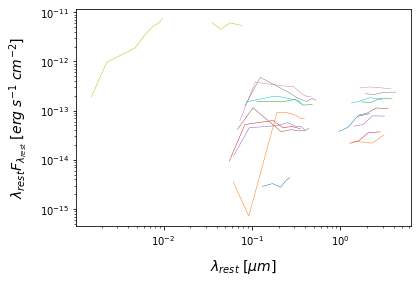

In [52]:
# plot curves for 10 sources 
for i in range(10) : 
    # plt.plot(lam_um, agn_lamflux_lam_ergscm2[i])
    plt.plot(lamR_um[i], agn_lamflux_lam_ergscm2[i])

# axis
plt.yscale('log')
plt.xscale('log')
# plt.xlim(0.05, 150)

# set lables 
# plt.title('SEDs for 10 AGN') 
plt.xlabel('$\lambda_{rest} \; [\mu m]$') # specify REST frame wavelength 
plt.ylabel('$\lambda_{rest} F_{\lambda_{rest}} \; [erg \; s^{-1} \; cm^{-2}]$')

# show plot
plt.show()